# CS 513: Project - Market Trend Classification

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## data loading

In [2]:
ticker = "TSLA"
df = yf.download(ticker, start="2020-01-01", end="2024-01-01")

/var/folders/gg/4qvn_q555hgd_cgw8phv4mqw0000gn/T/ipykernel_62223/1410413630.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


## feature engineering

In [3]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df['Open-Close'] = df['Open'] - df['Close']
df['High-Low'] = df['High'] - df['Low']
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['Volatility'] = df['Close'].rolling(window=5).std()

# drop NaNs created by rolling windows
df = df.dropna()

# select features and target
features = ['Open-Close', 'High-Low', 'MA_5', 'MA_10', 'Volatility']
X = df[features]
y = df['Target']

## data preprocessing

In [4]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")

Training Samples: 797 | Testing Samples: 200


## model implementation

In [5]:
models = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

## training and evaluation

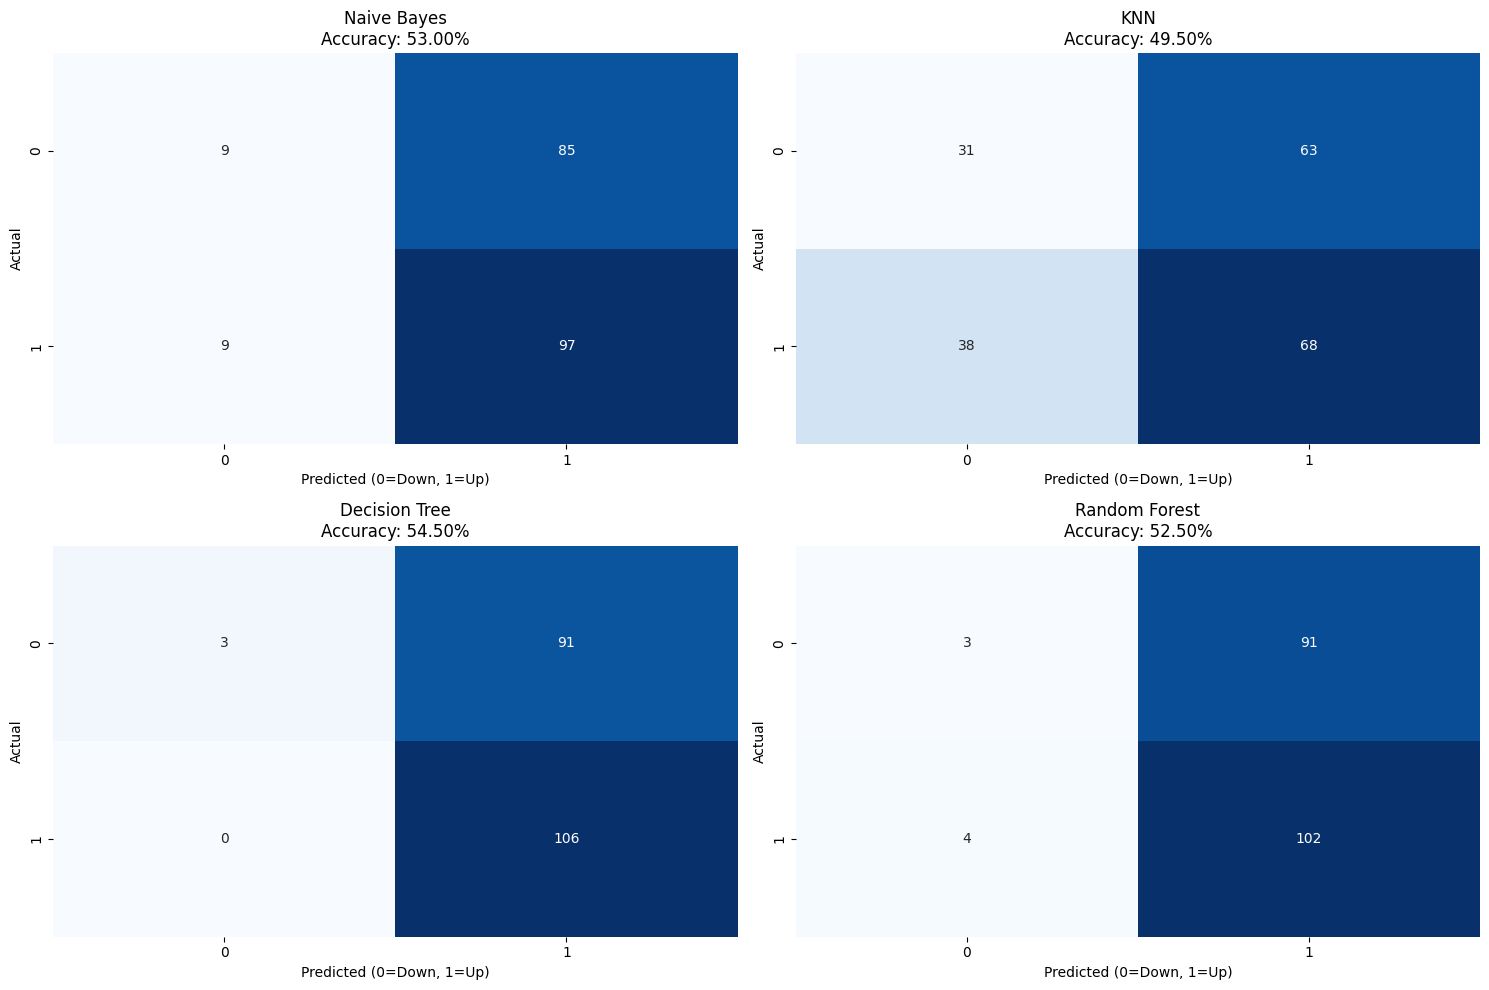

In [6]:
plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(models.items()):
    # train
    model.fit(X_train_scaled, y_train)
    
    # predict
    y_pred = model.predict(X_test_scaled)
    
    # evaluate
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name}\nAccuracy: {acc:.2%}")
    plt.xlabel('Predicted (0=Down, 1=Up)')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## visualization

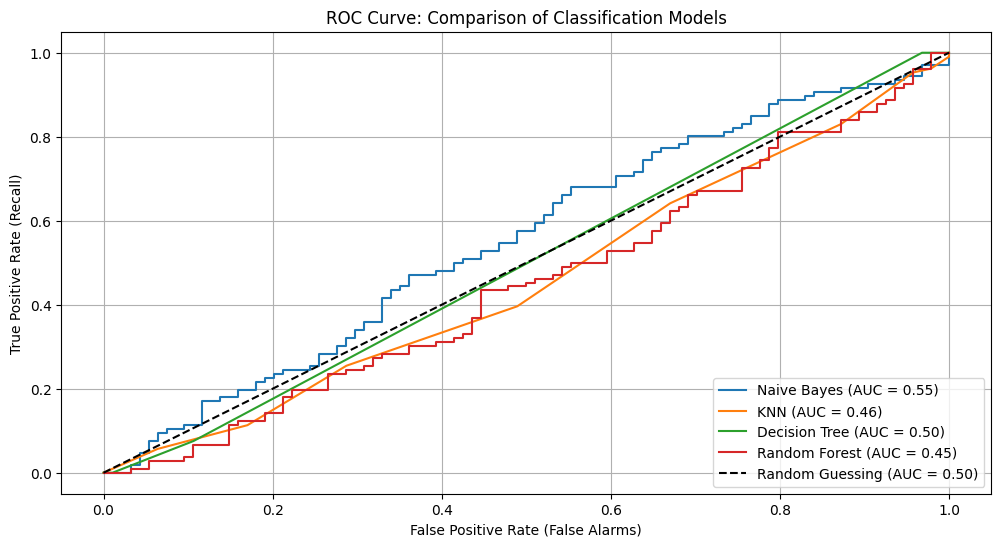

In [7]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        except:
            pass

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: Comparison of Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## feature importance

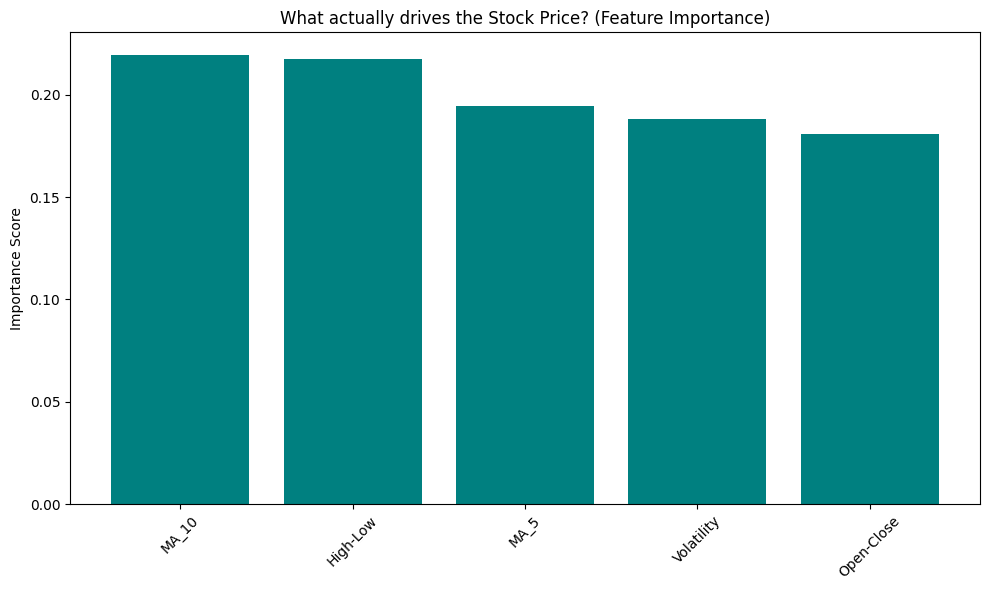

Backtesting with Best Model: Decision Tree


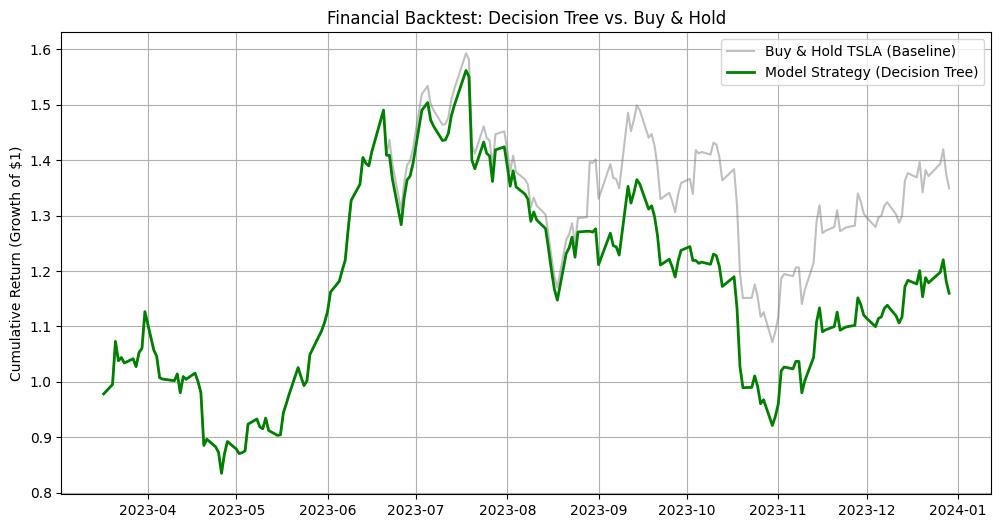

In [8]:
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("What actually drives the Stock Price? (Feature Importance)")
    plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Backtesting with Best Model: {best_model_name}")

backtest = df.iloc[split_index:].copy()
backtest['Predicted_Signal'] = best_model.predict(X_test_scaled)

backtest['Market_Return'] = backtest['Close'].pct_change()
backtest['Strategy_Return'] = backtest['Market_Return'] * backtest['Predicted_Signal']

backtest['Cumulative_Market'] = (1 + backtest['Market_Return']).cumprod()
backtest['Cumulative_Strategy'] = (1 + backtest['Strategy_Return']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(backtest['Cumulative_Market'], label='Buy & Hold TSLA (Baseline)', color='gray', alpha=0.5)
plt.plot(backtest['Cumulative_Strategy'], label=f'Model Strategy ({best_model_name})', color='green', linewidth=2)
plt.title(f'Financial Backtest: {best_model_name} vs. Buy & Hold')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True)
plt.show()

## summary

In [9]:
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

results_df = results_df.sort_values(by='Accuracy', ascending=False)

results_df = results_df.reset_index(drop=True)

print("\nFINAL MODEL COMPARISON")
display(results_df)

winner = results_df.iloc[0]
print(f"\nWINNING MODEL: {winner['Model']}")
print(f"   Accuracy: {winner['Accuracy']:.2%}")
print(f"   Conclusion: The {winner['Model']} is the best suited algorithm for this dataset.")


FINAL MODEL COMPARISON


,Model,Accuracy
0,Decision Tree,0.545
1,Naive Bayes,0.530
2,Random Forest,0.525
3,KNN,0.495



WINNING MODEL: Decision Tree
   Accuracy: 54.50%
   Conclusion: The Decision Tree is the best suited algorithm for this dataset.
